In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Create the Jacobian

In [89]:
# From Prather, X value estimated from his final Jacobian values

# Initial mixing ratios (ppb)
y = np.array([1704, 100, 0.000026])  # [CH4, CO, OH] # modern global mean = 1938 ppb; Prather 2007 = 1704 ppb for methane
x_ppb = 0.001  # External sink species (held constant)

# Source Terms (ppb yr-1)
S = np.array([177, 240, 1464])  # [S_CH4, S_CO, S_OH]

# Reaction rates (converted to per year)
k5 = 1.266e-4 * 3.156e7  # CH4 + OH (yr-1 ppb-1)
k6 = 5.08e-3 * 3.156e7   # CO + OH (yr-1 ppb-1)
k7 = 1062 * 3.156e7      # OH + X (yr-1)

# Reaction function with x included only internally
def reaction_rates(y):
    ch4, co, oh = y
    R5 = k5 * ch4 * oh
    R6 = k6 * co * oh
    R7 = k7 * oh * x_ppb  # OH loss to external X
    dCH4dt = S[0] - R5
    dCOdt = S[1] + R5 - R6
    dOHdt = S[2] - R5 - R6 - R7
    return np.array([dCH4dt, dCOdt, dOHdt])

# Base rate
base_rates = reaction_rates(y)

# Jacobian (numerical)
pert = 1  # 1 ppb
J = np.zeros((3, 3))

for i in range(3):
    y_pert = y.copy()
    y_pert[i] += pert
    pert_rates = reaction_rates(y_pert)
    J[:, i] = (pert_rates - base_rates) / pert

# Display Jacobian
species = ["CH4", "CO", "OH"]
print("Jacobian J (∂(d[species]/dt)/∂[species]) in ppb/yr per ppb:")
for i in range(3):
    for j in range(3):
        print(f"∂(d[{species[i]}]/dt)/∂[{species[j]}] = {J[i,j]:.6e}")


Jacobian J (∂(d[species]/dt)/∂[species]) in ppb/yr per ppb:
∂(d[CH4]/dt)/∂[CH4] = -1.038829e-01
∂(d[CH4]/dt)/∂[CO] = 0.000000e+00
∂(d[CH4]/dt)/∂[OH] = -6.808325e+06
∂(d[CO]/dt)/∂[CH4] = 1.038829e-01
∂(d[CO]/dt)/∂[CO] = -4.168445e+00
∂(d[CO]/dt)/∂[OH] = -9.224155e+06
∂(d[OH]/dt)/∂[CH4] = -1.038829e-01
∂(d[OH]/dt)/∂[CO] = -4.168445e+00
∂(d[OH]/dt)/∂[OH] = -5.635753e+07


In [99]:

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(J)

# Compute lifetimes (in years)
T_years = -1 / eigenvalues

# Print results
print("Eigenvalues:")
for i, val in enumerate(eigenvalues):
    print(f"  λ{i+1} = {val:.4e}")

print("\nPerturbation lifetimes (in years):")
for i, T in enumerate(T_years):
    print(f"  Mode {i+1}: {T.real:.9f} years")

print("\nEigenvectors (columns are eigenmodes):")
print(eigenvectors)



t = np.arange(0, 100, 5)

delta_ch4_1ppb = 0.995*np.exp(-t/T_years[1])+0.005*np.exp(-t/T_years[2])

delta_ch4_trad = np.exp(-t/9.626224)

Eigenvalues:
  λ1 = -5.6358e+07
  λ2 = -7.3495e-02
  λ3 = -3.5040e+00

Perturbation lifetimes (in years):
  Mode 1: 0.000000018 years
  Mode 2: 13.606280603 years
  Mode 3: 0.285386143 years

Eigenvectors (columns are eigenmodes):
[[ 1.18381327e-01 -9.99373217e-01 -1.45978241e-01]
 [ 1.60387135e-01 -3.54001732e-02  9.89287801e-01]
 [ 9.79929502e-01  4.46047713e-09 -7.29029032e-08]]


In [103]:
# Checking delta_ch4_1ppb equation from matric projection (not just copying Prather's text)
# X0 = V*c where c is intial conditions
# so c=V_inverse*X0
# Methane looks right but CO is lower than Prather's 0.005 (ignored OH)

Init_1ppb = np.array( [1, 0, 0] ) #sticking with 3x3 even though Prather drops OH
V_inv = np.linalg.inv(eigenvectors) #inverse of the eignvectors
coeffs = V_inv @ Init_1ppb

for i in range(3):
    print(f"Mode {i+1}:")
    print(f"  Eigenvalue (decay rate): {eigenvalues[i]:.4f}")
    print(f"  Lifetime: {-1/eigenvalues[i]:.2f} years")
    print(f"  Contribution coefficient: {coeffs[i]:.4f}")


Mode 1:
  Eigenvalue (decay rate): -56357525.8788
  Lifetime: 0.00 years
  Contribution coefficient: 0.0000
Mode 2:
  Eigenvalue (decay rate): -0.0735
  Lifetime: 13.61 years
  Contribution coefficient: -0.9954
Mode 3:
  Eigenvalue (decay rate): -3.5040
  Lifetime: 0.29 years
  Contribution coefficient: -0.0356


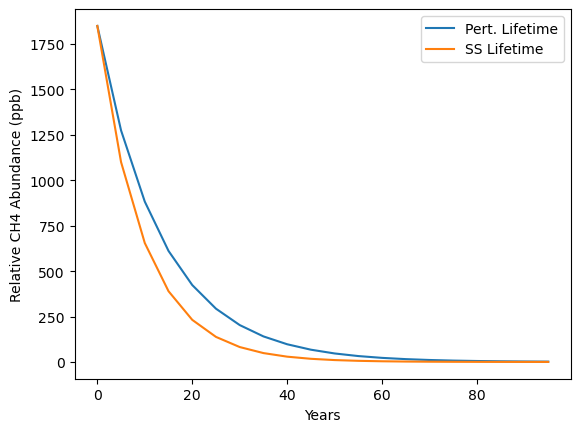

In [104]:
plt.plot(t,1850*delta_ch4_1ppb)
plt.plot(t, 1850*delta_ch4_trad)
plt.xlabel('Years')
plt.ylabel("Relative CH4 Abundance (ppb)")
plt.legend(["Pert. Lifetime", "SS Lifetime"])

In [106]:
diag = np.diag(J)
species = ["CH4", "CO", "OH"]

print("Negative Inverse of Diagonal of Jacobian (∂(d[species]/dt)/∂[same species]): Traditional Lifetime")
for i in range(3):
    print(f"∂(d[{species[i]}]/dt)/∂[{species[i]}] = {-1/diag[i]:.6e}")

Negative Inverse of Diagonal of Jacobian (∂(d[species]/dt)/∂[same species]): Traditional Lifetime
∂(d[CH4]/dt)/∂[CH4] = 9.626224e+00
∂(d[CO]/dt)/∂[CO] = 2.398976e-01
∂(d[OH]/dt)/∂[OH] = 1.774386e-08
